## Week of 27th April to 4th May 2020 Ussd Events Analysis

#### Investigate:

- Number of Events as they took place Hourly -  between Midday to 9 pm
- USSD Requests Proportion of users (registered users)
- Overall failures for the period (registered users)
- Number of USSD requests by day (registered users)
- USSD failure rates by day (registered users)


##### Kindly note that the results of this analysis are not reflective of events whose phone numbers (56) were not captured by the monitoring tool as these were dropped to fit the objectives of the analysis.

##### Data Sources:
- USSD Events: http://209.97.136.146:8080/browse/2

- Registered users: http://197.254.84.134:8082/api/customer/list

##### Settings & libraries

In [89]:
import pandas as pd
import numpy as np
import scipy as scp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import re
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
ColorPicker=widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
DatePicker=widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


##### Read in & Explore Data

In [90]:
events=pd.read_csv('events.csv')
print(events.isnull().sum())
print('\n')
print(events.shape)
print('\n')
events.head()

ID                0
Customer      53344
Date Added     3970
Outcome           0
Phone           170
Response          0
Task              0
dtype: int64


(53344, 7)




,ID,Customer,Date Added,Outcome,Phone,Response,Task
0,106695,NaN,2020-05-04T08:22:31+03:00,SUCCESS,2.547640e+11,Order placed successfully,SubmitOrder
1,106693,NaN,2020-05-04T08:21:03+03:00,SUCCESS,2.547640e+11,Phone number found,Dial
2,106691,NaN,2020-05-04T07:38:17+03:00,SUCCESS,2.547644e+11,Order placed successfully,SubmitOrder
3,106689,NaN,2020-05-04T07:37:30+03:00,SUCCESS,2.547644e+11,Phone number found,Dial
4,106687,NaN,2020-05-04T07:15:27+03:00,SUCCESS,2.547645e+11,Order placed successfully,SubmitOrder


##### Create Date & Time columns from 'Date Added' 

In [91]:
events['Date']=events['Date Added'].str[:10]
events['Time']=events['Date Added'].str[11:19]

##### Convert 'Date' to datetime to be able to calculate time delta

In [92]:
events['Date']=pd.to_datetime(events['Date'])

##### Filter Data between 27th April & 4th May 2020; the period of interest

In [93]:
events=events[(events['Date']>='2020-04-27')&(events['Date']<'2020-05-04')]

##### Check number of null values after filtering events for the period of interest

In [94]:
print(events.isnull().sum())
print('\n')
print(events.shape)
print('\n')

ID               0
Customer      5441
Date Added       0
Outcome          0
Phone           56
Response         0
Task             0
Date             0
Time             0
dtype: int64


(5441, 9)




##### The entire customer column has null values, we drop it.

In [95]:
events.drop(['Customer'], axis=1,inplace=True)

##### Create 'Hour' column from 'Time'

In [96]:
events['Hour']=events['Time'].str[:2]+'00hrs'
events.head()

,ID,Date Added,Outcome,Phone,Response,Task,Date,Time,Hour
14,106667,2020-05-03T20:05:12+03:00,SUCCESS,2.547639e+11,Order placed successfully,SubmitOrder,2020-05-03,20:05:12,2000hrs
15,106665,2020-05-03T20:04:21+03:00,SUCCESS,2.547639e+11,Phone number found,Dial,2020-05-03,20:04:21,2000hrs
16,106663,2020-05-03T19:30:33+03:00,SUCCESS,2.547637e+11,Order placed successfully,SubmitOrder,2020-05-03,19:30:33,1900hrs
17,106661,2020-05-03T19:28:32+03:00,SUCCESS,2.547637e+11,Phone number found,Dial,2020-05-03,19:28:32,1900hrs
18,106659,2020-05-03T18:57:55+03:00,SUCCESS,2.547642e+11,Order placed successfully,SubmitOrder,2020-05-03,18:57:55,1800hrs


### 1. No. of Events as they took place Hourly -  between midday to 9 pm

##### filter events between mid day and 9pm

In [97]:
midday_to_9pm=events[(events['Hour']>='12')&(events['Hour']<'21')]

##### plot events by hour between midday and 2100hrs

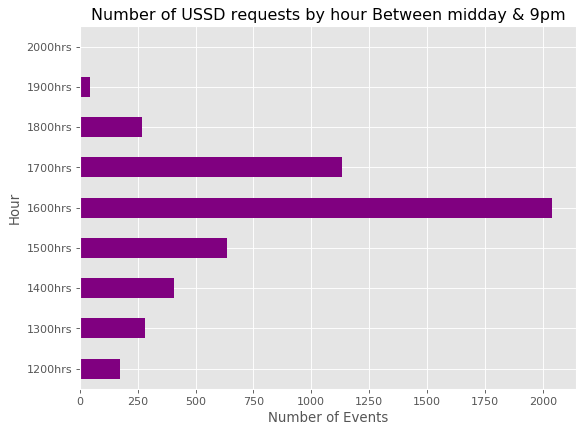

In [98]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
midday_to_9pm['Hour'].value_counts().sort_index().plot.barh(color='purple')
plt.title('Number of USSD requests by hour Between midday & 9pm')
plt.xlabel('Number of Events')
plt.ylabel('Hour')
plt.figtext(.8, .8, "")
plt.show()

##### most ussd dials during the week occured between 1500hrs and 1700hrs, peak period being 1600hrs

### 2. Proportion of registered USSD request users

##### Drop Events (56) with no phone numbers since we now want to check if users are registered for ussd or not

In [99]:
events=events[events['Phone'].notna()]

##### USSD Requests are ussd dials, filter data where task is 'Dial'

In [100]:
ussd_requests=events[events['Task']=='Dial']

##### Clean 'Phone' column

In [101]:
ussd_requests['Phone']=ussd_requests['Phone'].astype(str).str[0:12]

##### Get all registered users from customer's API
http://197.254.84.134:8082/api/customer/list
##### Read in api content  as text file and retrieve phone numbers

In [102]:
customers=pd.read_fwf('customers.txt',names=['Number'])
registered=[]
for string in customers['Number']:
    if '<PhoneNumber>' in string:       
        if len(string)==39:            
            number=string[13:25]
            registered.append(number)
            
print(len(registered))
registered[:5]

588


['254764719863',
 '254763952674',
 '254764019493',
 '254764666544',
 '254724589504']

##### Check number of registered users who dialed and those who didnt dial ussd during the period 

In [103]:
dialed=ussd_requests['Phone'].drop_duplicates().to_list()
def registered_dialed_or_didnt(list1,list2):
    RegisteredDialedOrNot=[] 
    for number in list1:
        if number in list2:
            RegisteredDialedOrNot.append('Dialed')
        else:
            RegisteredDialedOrNot.append('Didnt Dial')
    return RegisteredDialedOrNot
RegisteredDialedOrNot=registered_dialed_or_didnt(registered,dialed)
RegisteredDialedOrNot=pd.Series(RegisteredDialedOrNot)
RegisteredDialedOrNot.value_counts()

Dialed        334
Didnt Dial    254
dtype: int64

##### Plot dialed or didnt dial

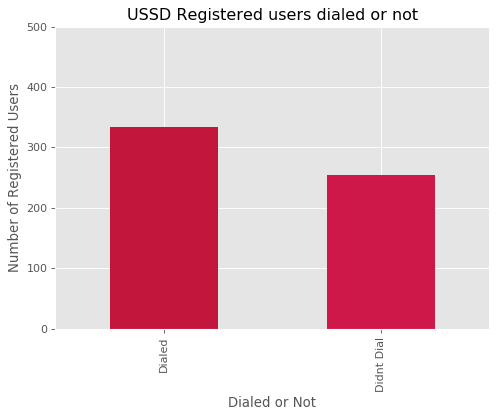

In [116]:
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
RegisteredDialedOrNot.value_counts().sort_index().plot.bar(color=['#c2163d','#cf184a'])
plt.title('USSD Registered users dialed or not')
plt.ylabel('Number of Registered Users')
plt.xlabel('Dialed or Not')
plt.ylim(0,500)
plt.show()

### 3. Overall USSD requests failure rate for registered users

##### Create a new column for RegisteredOrNot for each ussd dial

In [105]:
DailedRegisteredOrNot=[]
for number in ussd_requests['Phone']:
    if number in registered:
        DailedRegisteredOrNot.append('Registered')
    else:
        DailedRegisteredOrNot.append('Not Registered')
ussd_requests['RegisteredOrNot']=DailedRegisteredOrNot
ussd_requests['RegisteredOrNot'].value_counts()

Registered        3488
Not Registered      61
Name: RegisteredOrNot, dtype: int64

##### Of the total ussd requests during the period, 3,488 were by registered users while 61 were by non-registered users

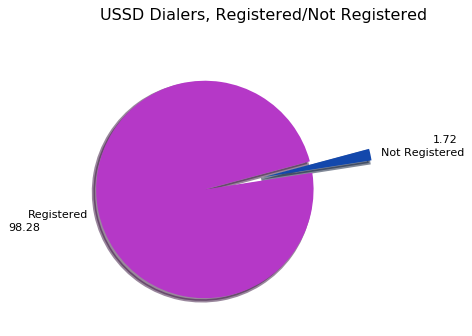

In [106]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.pie(ussd_requests['RegisteredOrNot'].value_counts(),autopct='%1.2f',labels=['Registered','Not Registered'],\
        colors=['#b538c7','#1348ac'],\
        pctdistance=1.7,shadow=True,radius=0.9,startangle=15,explode=[0.5,.001],wedgeprops = {'linewidth': 3})
plt.title('USSD Dialers, Registered/Not Registered')
plt.show()

##### keep ussd requests for only registered users

In [108]:
ussd_requests=ussd_requests[ussd_requests['RegisteredOrNot']=='Registered']

##### plot USSD outcomes

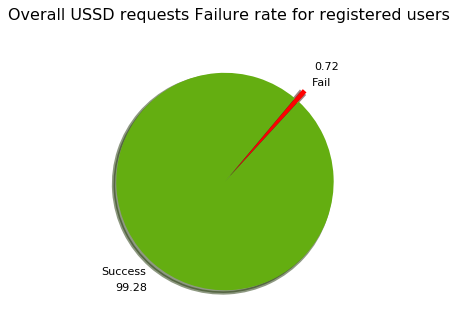

In [109]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.pie(ussd_requests['Outcome'].value_counts(),autopct='%1.2f',labels=['Success','Fail'],colors=['#64ae11','r'],\
        pctdistance=1.3,shadow=True,radius=0.9,startangle=50,explode=[0.05,0.05],wedgeprops = {'linewidth': 3})
plt.title('Overall USSD requests Failure rate for registered users')
plt.show()

##### 99.28% of ussd requests by registered users were successful

### 4. Number of USSD requests by day for registered users

##### Create Day of Week column from Date

In [110]:
days_of_week=[]
for date in ussd_requests['Date'].to_list():
    day_of_week=date.strftime("%A")
    days_of_week.append(day_of_week)
ussd_requests['Day of Week']=days_of_week

days=[]
for day in ussd_requests['Day of Week']:
    if day=='Monday':
        days.append(1)
    elif day=='Sunday':
        days.append(0)
    elif day=='Tuesday':
        days.append(2)
    elif day=='Wednesday':
        days.append(3)
    elif day=='Thursday':
        days.append(4)
    elif day=='Friday':
        days.append(5)
    elif day=='Saturday':
        days.append(6)
ussd_requests['Day']=days

##### Plot ussd requests by day for registered users

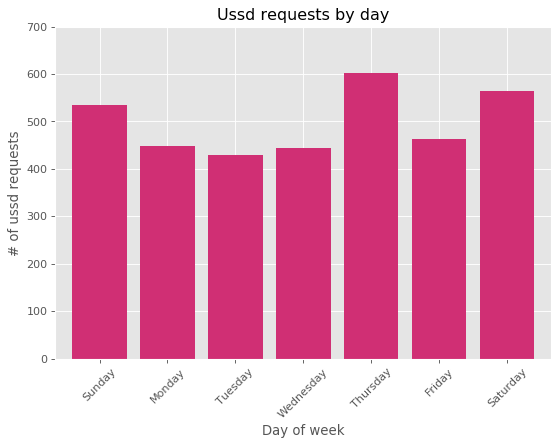

In [111]:
ussd_requests.sort_values(by='Day')
plt.figure(num=None, figsize=(8,5.5), dpi=80, facecolor='w', edgecolor='k')
ax=ussd_requests['Day'].value_counts().sort_index().plot.bar(color='#d02f74',width=0.8)
plt.title('Ussd requests by day')
plt.ylabel('# of ussd requests')
plt.xlabel('Day of week')
plt.ylim(0,700)
x_labels=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
ax.set_xticklabels(x_labels)
plt.xticks(rotation=45)
plt.figtext(.8, .8, "")
plt.show()

### 5. USSD requests failure rates by day for registered users

##### Group data by Outcome and day of week to view numbers for each day

In [112]:
ussd_requests.groupby(['Outcome','Day of Week']).count()['Task']

Outcome  Day of Week
ERROR    Friday           1
         Monday          10
         Thursday         6
         Wednesday        8
SUCCESS  Friday         462
         Monday         439
         Saturday       565
         Sunday         535
         Thursday       596
         Tuesday        429
         Wednesday      437
Name: Task, dtype: int64

##### Plot Failure rates by day

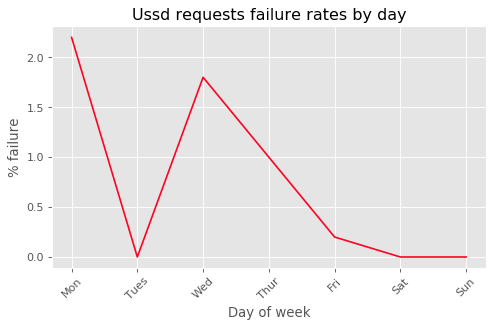

In [113]:
days=['Mon','Tues','Wed','Thur','Fri','Sat','Sun']
failure_rates=[2.2,0,1.8,1.0,0.2,0,0]
plt.figure(num=None, figsize=(7,4), dpi=80, facecolor='w', edgecolor='k')
sns.lineplot(x=days, y=failure_rates,sort=False,color='#fa0524')
plt.title('Ussd requests failure rates by day')
plt.ylabel('% failure')
plt.xlabel('Day of week')
# plt.ylim(0,5)
plt.xticks(rotation=45)
plt.show()

##### Plot USSD failures against success by day

<Figure size 4000x1600 with 0 Axes>

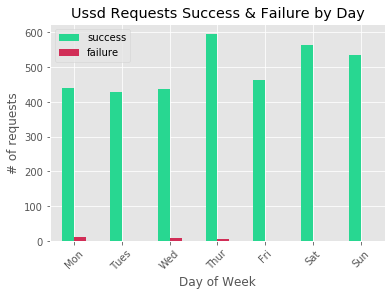

In [114]:
days=['Mon','Tues','Wed','Thur','Fri','Sat','Sun']
successes=[439,429,437,596,462,565,535]
failures=[10,0,8,6,1,0,0]
df = pd.DataFrame(np.c_[successes,failures], index=days)
plt.figure(num=None, figsize=(20,8), dpi=200, facecolor='w', edgecolor='k')
df.plot.bar(color=['#28d791','#d12e57'])
plt.title('Ussd Requests Success & Failure by Day')
plt.xlabel('Day of Week')
plt.ylabel('# of requests')
plt.legend(['success','failure'])
plt.yscale(value='linear')
plt.xticks(rotation=45)
plt.show()

In [115]:
ColorPicker

ColorPicker(value='blue', description='Pick a color')

In [81]:
DatePicker

DatePicker(value=None, description='Pick a Date')